<a href="https://colab.research.google.com/github/SaumilShah-7/Dog-Breed-Identification-Kaggle/blob/master/Dog_Breed_Identification_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from zipfile import ZipFile
import cv2

2.0.0-rc2


In [4]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [5]:
!kaggle competitions download -c dog-breed-identification

  0% 0.00/214k [00:00<?, ?B/s]
100% 214k/214k [00:00<00:00, 69.4MB/s]
  0% 0.00/281k [00:00<?, ?B/s]
100% 281k/281k [00:00<00:00, 92.5MB/s]
 98% 338M/346M [00:02<00:00, 135MB/s]
100% 346M/346M [00:02<00:00, 156MB/s]
100% 343M/345M [00:03<00:00, 156MB/s]
100% 345M/345M [00:03<00:00, 117MB/s]


In [0]:
with ZipFile('train.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('test.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('labels.csv.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('labels.csv.zip', 'r') as zipobj:
  zipobj.extractall()
with ZipFile('sample_submission.csv.zip', 'r') as zipobj:
  zipobj.extractall()

In [0]:
y_df = pd.read_csv('labels.csv')
y_labels = np.asarray(y_df['breed']).reshape(-1, 1)

image_height = 128
image_width = 128

x = []
for i in y_df['id']:
  image = cv2.imread('/content/train/'+i+'.jpg')
  x.append(cv2.resize(image, (image_height, image_width)))
x = np.asarray(x)

In [0]:
ohe = OneHotEncoder()
y = ohe.fit_transform(y_labels).toarray()

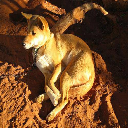

(128, 128, 3) ['dingo']


In [9]:
from google.colab.patches import cv2_imshow

cv2_imshow(x[1])
print(x[1].shape, y_labels[1])

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7, shuffle=True)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7155, 128, 128, 3) (3067, 128, 128, 3) (7155, 120) (3067, 120)


In [0]:
mean = np.mean(x_train, axis=0)
std_dev = np.std(x_train, axis=0)

x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

x_train-=mean
x_train/=std_dev

x_test-=mean
x_test/=std_dev

In [22]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(image_width,image_height,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(units=300,activation='relu'))
model.add(BatchNormalization())

model.add(Dense(units=120,activation='softmax'))

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)            

In [23]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=300, batch_size=500, callbacks=[es, mc])
saved_model = load_model('best_model.h5')

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 7155 samples, validate on 3067 samples
Epoch 1/300
7000/7155 [============================>.] - ETA: 0s - loss: 4.8552 - accuracy: 0.0213
Epoch 00001: val_accuracy improved from -inf to 0.02315, saving model to best_model.h5
7155/7155 [==============================] - 10s 1ms/sample - loss: 4.8504 - accuracy: 0.0214 - val_loss: 6.1768 - val_accuracy: 0.0231
Epoch 2/300
7000/7155 [============================>.] - ETA: 0s - loss: 4.2220 - accuracy: 0.0830
Epoch 00002: val_accuracy improved from 0.02315 to 0.03065, saving model to best_model.h5
7155/7155 [==============================] - 9s 1ms/sample - loss: 4.2202 - accuracy: 0.0832 - val_loss: 4.7639 - val_accuracy: 0.0306
Epoch 3/300
7000/7155 [============================>.] - ETA: 0s - loss: 3.7799 - accuracy: 0.1706
Epoch 00003: val_accuracy improved from 0.03065 to 0.03456, saving model to best_model.h5
7155/7155 [==============================] - 9s 1ms/sample - loss: 3.7786 - accuracy: 0.1697 - val_loss: 4.5876 - val

KeyboardInterrupt: ignored

In [0]:
train_metrics = saved_model.evaluate(x_train, y_train, verbose=0)
test_metrics = saved_model.evaluate(x_test, y_test, verbose=0)
print(train_metrics, test_metrics)